# Example of application to matlab files and (partial) replication of results from Borst and Anderson 2021

In [1]:
import numpy as np
import scipy.io
import os
import xarray as xr
import hsmm_mvpy as hsmm
import itertools
import multiprocessing 
import matplotlib.pyplot as plt
from mne import channels

cpus = 4

%load_ext autoreload
%autoreload 2


Reading the data

In [2]:
mat = scipy.io.loadmat('matlab/analysis_data_model/data/varForBumps135_100.mat')

data = np.array(mat['normedscore10'])
starts = np.array(mat['x'][:,0]) -1#correcting to be 0 indexed
ends = np.array(mat['y'][:,0])-1#correcting to be 0 indexed
subjects = np.array(mat['subjects'])-1 #correcting to be 0 indexed

#### Converting to xarray format 
durations = ends - starts + 1
limits = np.cumsum(durations)
limits = np.concatenate([[0],limits])
participant, trials = np.unique(subjects, return_counts=True)
# creating data watrix with participant x trial x max duration x electrodes/comp
unstacked_data = np.tile(np.nan, (len(participant), np.max(trials), np.shape(data)[1], np.max(durations)))
conditions = np.tile(np.nan, (len(participant), np.max(trials)))
for trial in np.arange(len(durations)):
    if trial > 0 and subjects[trial] == subjects[trial-1]:
        within_trial += 1
    else:
        within_trial = 0
    unstacked_data[subjects[trial], within_trial, :,:durations[trial],] = data[limits[trial]:limits[trial+1]].T
    conditions[subjects[trial], within_trial] = mat['conds'][trial]

unstacked_data = hsmm.utils.hsmm_data_format(unstacked_data, conditions, sfreq=100, participants=participant)
unstacked_data = unstacked_data.rename({'electrodes':'component'})#Data is already on PC space

In [3]:
unstacked_data

<xarray.Dataset>
Dimensions:      (participant: 20, epochs: 789, component: 10, samples: 300)
Coordinates:
  * participant  (participant) uint8 0 1 2 3 4 5 6 7 ... 12 13 14 15 16 17 18 19
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 ... 782 783 784 785 786 787 788
  * component    (component) int64 0 1 2 3 4 5 6 7 8 9
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 293 294 295 296 297 298 299
Data variables:
    data         (participant, epochs, component, samples) float64 2.294 ... nan
    event        (participant, epochs) float64 1.0 1.0 2.0 1.0 ... nan nan nan
Attributes:
    sfreq:    100

Recreating positions of electrodes

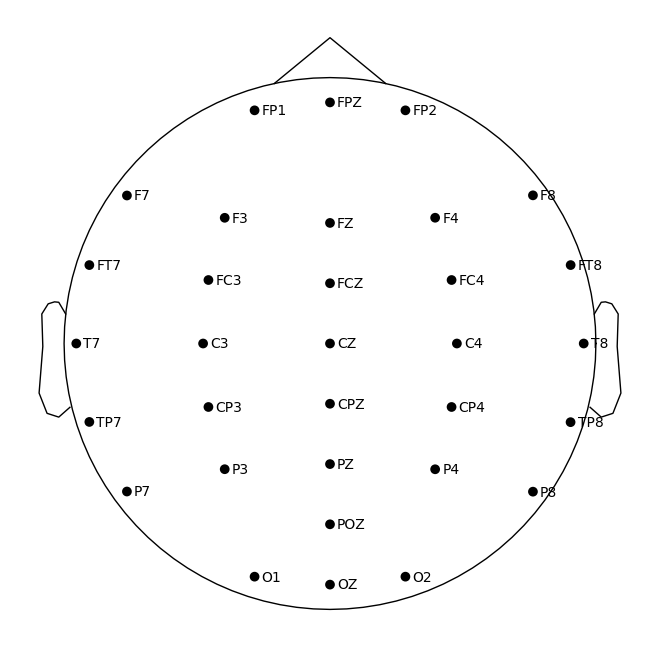

In [4]:
channels_loc = scipy.io.loadmat('matlab/analysis_data_model/analysis/HSMM_code/chanlocs.mat')
positions_dict_i =  [{str(electrode[0][0]):[-electrode[5][0][0]/1000,electrode[4][0][0]/1000,electrode[6][0][0]/1000]} 
                     for electrode in channels_loc['chanlocs'][0]]
positions_dict = {}
for i in positions_dict_i:
     positions_dict.update(i)
montage = channels.make_dig_montage(positions_dict,coord_frame='head')
positions = np.array([x[-1][:2] for x in np.array(list(montage.get_positions()['ch_pos'].items()),dtype=object)[:,:]])
names = np.array([x[0] for x in np.array(list(montage.get_positions()['ch_pos'].items()),dtype=object)[:,:]])
montage.plot();

Initializing the hsmm object with data, starts, sampling frequency... all things shared across the different following fit

In [5]:
stacked_data = hsmm.utils.stack_data(unstacked_data.data, 'participant')
init = hsmm.models.hsmm(stacked_data.data.T, starts, ends, sf=100, bump_width=50, cpus=4)

Estimating n_bump model with backward estimation

In [6]:
path = 'HsMM_estimation_files/'
filename = 'testing.nc'

if filename not in os.listdir(path):
    bests = init.backward_estimation(max_starting_points=200)
    bests.to_netcdf(path+filename)
else:
    bests = xr.open_dataset(path+filename, engine='netcdf4')
bests

<xarray.Dataset>
Dimensions:      (n_bumps: 8, stage: 9, params: 2, component: 10, bump: 8,
                  samples: 300, trial: 14496)
Coordinates:
  * n_bumps      (n_bumps) int64 8 7 6 5 4 3 2 1
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  (n_bumps) float64 ...
    parameters   (n_bumps, stage, params) float64 ...
    magnitudes   (n_bumps, component, bump) float64 ...
    eventprobs   (n_bumps, samples, trial, bump) float64 ...

Plotting the (raw) likelihood and estimatedbumps

In [7]:
electrodes = xr.DataArray(hsmm.utils.reconstruct(bests.magnitudes, mat['coeff10'][:,:10], 
                            mat['latent10'][:10], np.mean(mat['data'],axis=0)))

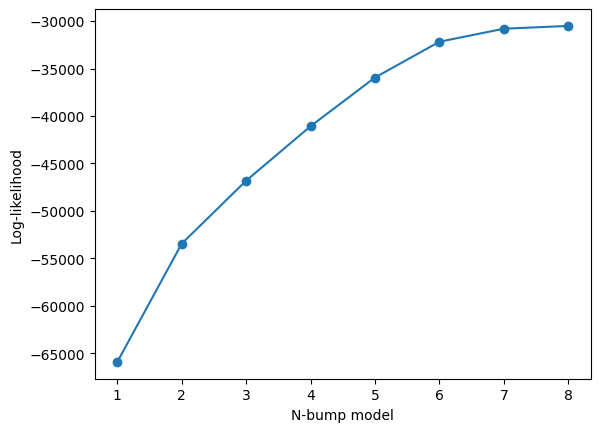

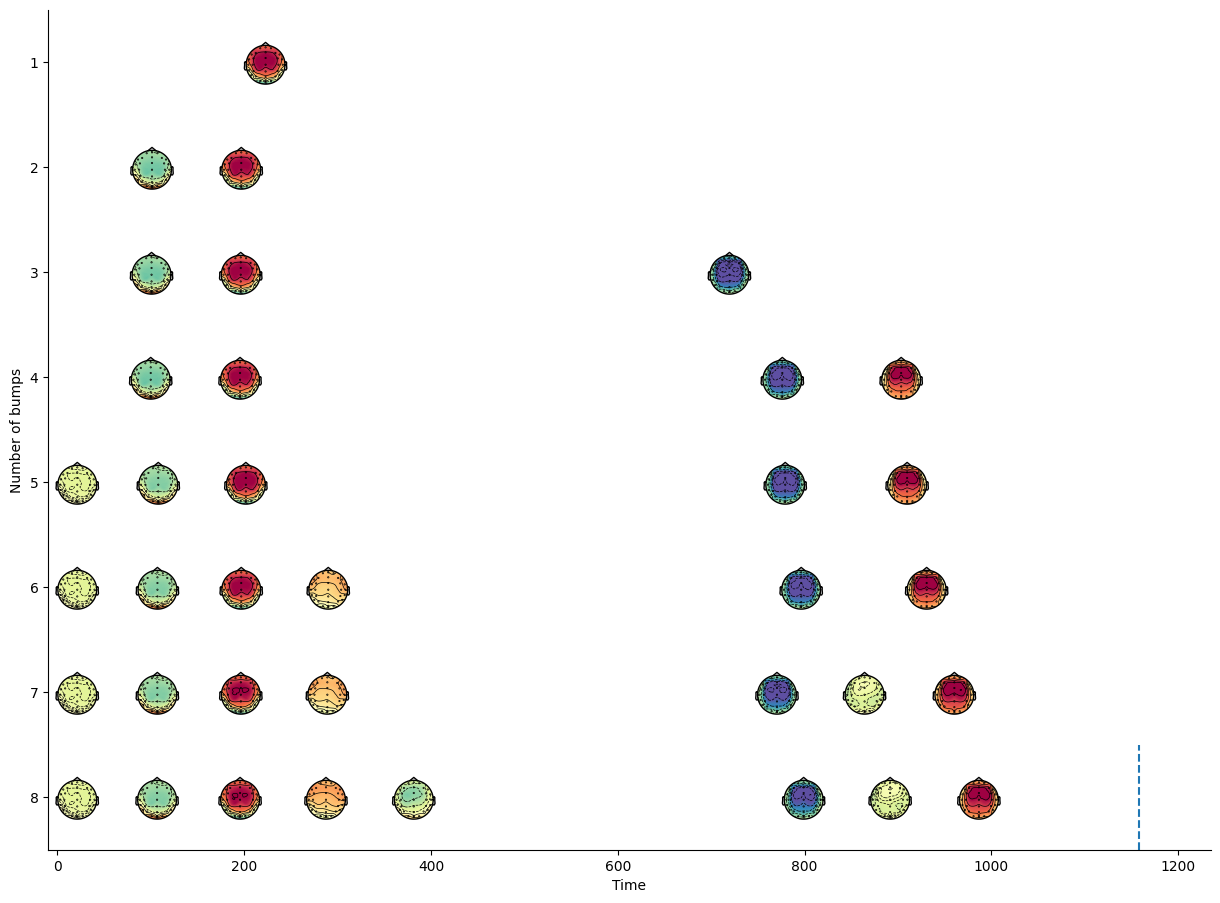

In [8]:
plt.plot(np.arange(init.max_bumps)+1, bests.likelihoods[::-1],'o-')
plt.ylabel('Log-likelihood')
plt.xlabel('N-bump model')
plt.show()
hsmm.visu.plot_topo_timecourse(electrodes, [np.mean(init.bump_times(x),axis=0) for x in bests.eventprobs], positions, bump_size=5, 
                          time_step = 10, magnify=2, times_to_display = np.mean(ends- starts),
    figsize=(15,10), ylabels={'Number of bumps':np.arange(init.max_bumps, 0,-1)},
    vmin=-10, vmax=10)

Applying LOOCV procedure

In [9]:
path = 'HsMM_estimation_files/'
filename = 'testing_loocv.nc'

if filename not in os.listdir(path):
    subjects_idx = unstacked_data.participant.data
    likelihoods_loo = []
    cpus = 4
    all_n_bumps = []
    for n_bumps in np.arange(1,init.max_bumps+1):    
        with multiprocessing.Pool(processes=cpus) as pool:
            loo = pool.starmap(hsmm.utils.LOOCV, 
                zip(itertools.repeat(unstacked_data), subjects_idx, itertools.repeat(n_bumps), 
                    itertools.repeat(bests.sel(n_bumps=n_bumps)), itertools.repeat(100)))
        all_n_bumps.append(loo)

    loocv = xr.DataArray(np.array(all_n_bumps)[:,:,0].astype(np.float64), coords={"n_bump":np.arange(1,init.max_bumps+1),
                                                           "participants":np.array(all_n_bumps)[0,:,1]})
    loocv.to_netcdf(path+filename)
else:
    loocv = xr.open_dataset(path+filename)
loocv

<xarray.Dataset>
Dimensions:                        (n_bump: 8, participants: 20)
Coordinates:
  * n_bump                         (n_bump) int64 1 2 3 4 5 6 7 8
  * participants                   (participants) float64 0.0 1.0 ... 18.0 19.0
Data variables:
    __xarray_dataarray_variable__  (n_bump, participants) float64 ...

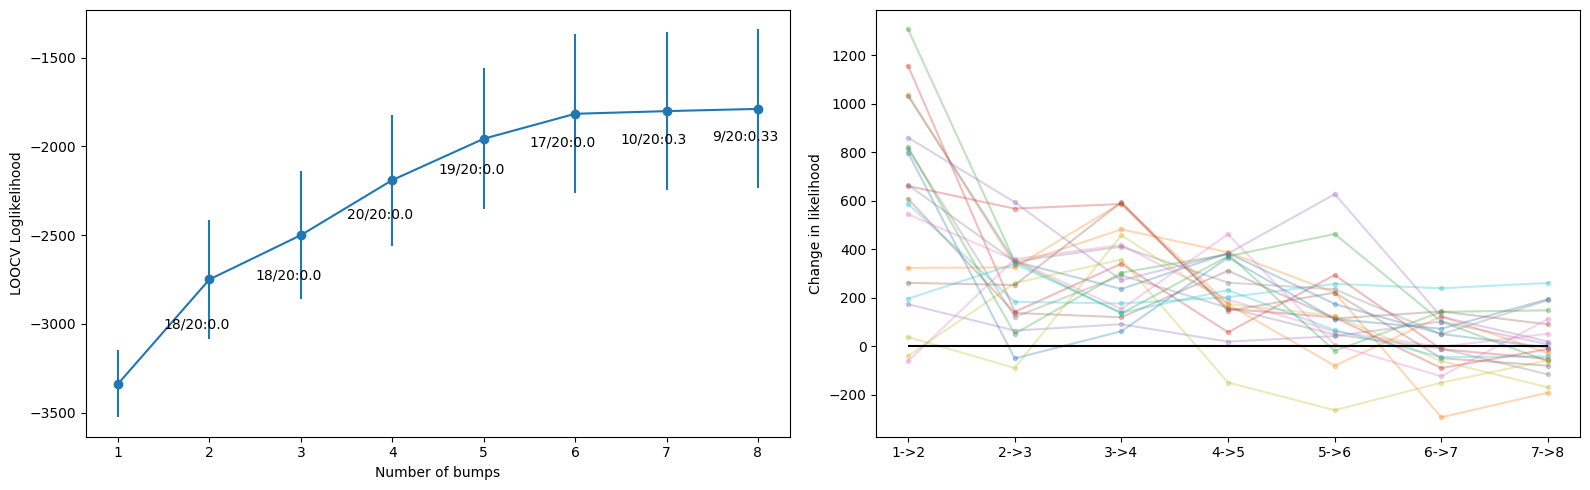

In [11]:
hsmm.visu.plot_LOOCV(loocv.__xarray_dataarray_variable__, test='t-test', indiv=False)

Selecting 6 bumps model

In [12]:
selected = bests.sel(n_bumps=6)
bump_times_selected = init.bump_times(selected.eventprobs.dropna('bump'))
mean_bump_times_selected = np.mean(bump_times_selected, axis=0)
electrodes_selected = xr.DataArray(hsmm.utils.reconstruct(selected.magnitudes, mat['coeff10'][:,:10], 
                            mat['latent10'][:10], np.mean(mat['data'],axis=0)))

Zoom on topologies

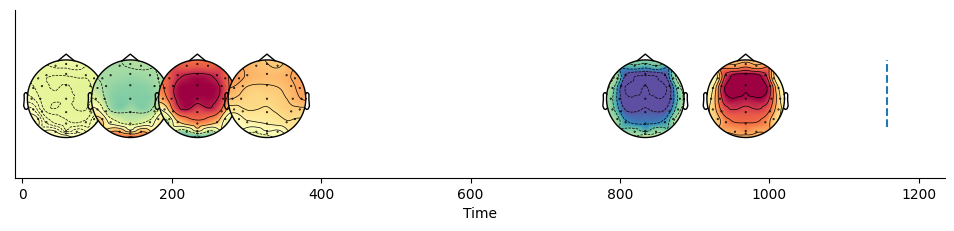

In [13]:
hsmm.visu.plot_topo_timecourse(electrodes_selected, mean_bump_times_selected, positions, 
                               bump_size=init.bump_width_samples, magnify=5, figsize=(12,2),
                                time_step = 1000/init.sf,  times_to_display = np.mean(ends - starts),
                                ylabels='5 bumps model', vmin=-10, vmax=10)

Plotting the average duration of the stages + bootstrapped confidence intervals (group-level not participant level)

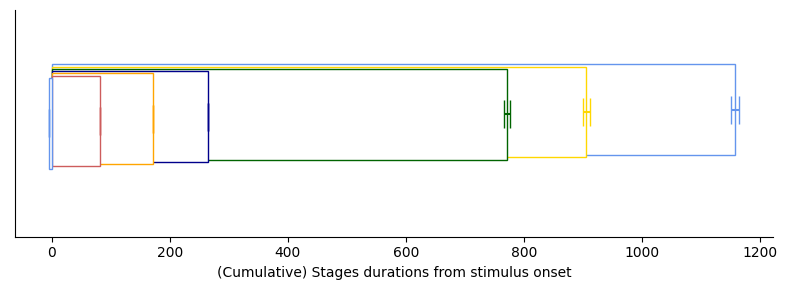

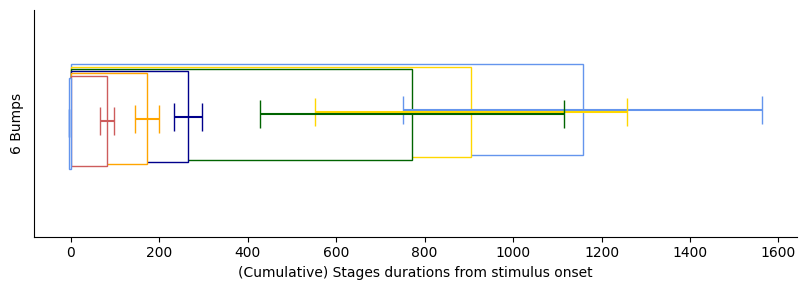

In [14]:
ax = hsmm.visu.plot_latencies_average(bump_times_selected, init.bump_width_samples, 1000/init.sf, 
            errs='ci')
ax = hsmm.visu.plot_latencies_average(bump_times_selected, init.bump_width_samples, 1000/init.sf, 
            errs='std')
ax.set_ylabel('6 Bumps');


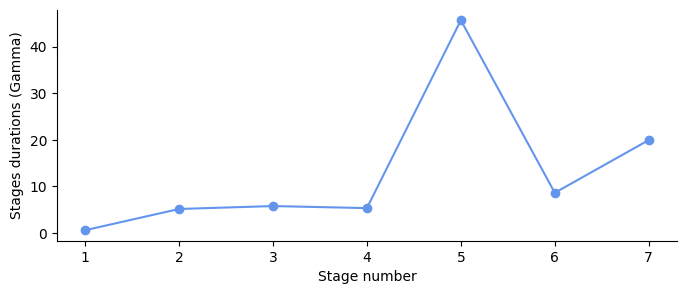

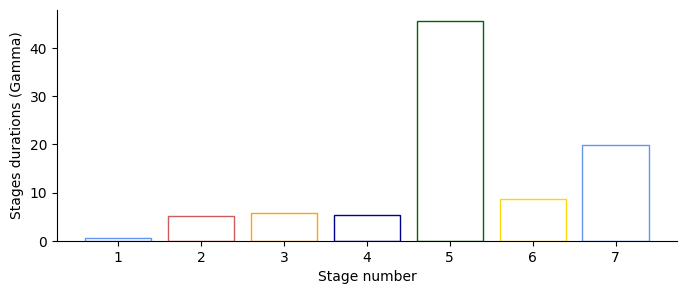

In [15]:
hsmm.visu.plot_latencies_gamma(selected.parameters.dropna('stage').values, init.bump_width_samples, kind='point');
hsmm.visu.plot_latencies_gamma(selected.parameters.dropna('stage').values, init.bump_width_samples, kind='bar');

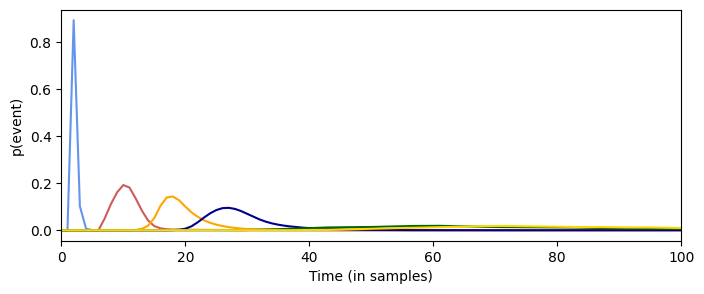

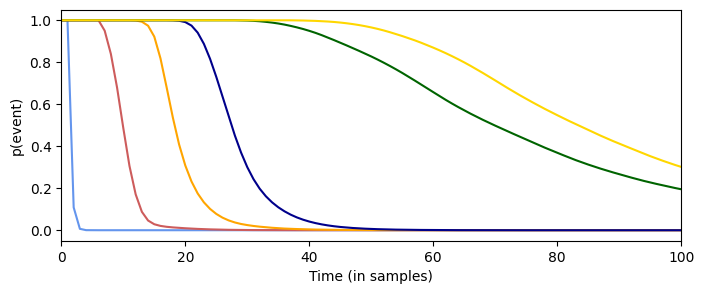

In [16]:
hsmm.visu.plot_distribution(selected.eventprobs.mean(dim=['trial']), xlims=(0,100))
hsmm.visu.plot_distribution(selected.eventprobs.mean(dim=['trial']), xlims=(0,100), survival=True);

# Condition wise analysis

In [17]:
subset = unstacked_data.where(unstacked_data.event == 1).data
hsmm_1_data = hsmm.utils.stack_data(subset,'participant')
init_1 = hsmm.models.hsmm(hsmm_1_data.data.T, hsmm_1_data.starts.data, hsmm_1_data.ends.data, 
                       sf=unstacked_data.sfreq, cpus=cpus, estimate_magnitudes=False)

subset = unstacked_data.where(unstacked_data.event == 2).data
hsmm_2_data = hsmm.utils.stack_data(subset,'participant')
init_2 = hsmm.models.hsmm(hsmm_2_data.data.T, hsmm_2_data.starts.data, hsmm_2_data.ends.data, 
                       sf=unstacked_data.sfreq, cpus=cpus, estimate_magnitudes=False)

subset = unstacked_data.where(unstacked_data.event == 3).data
hsmm_3_data = hsmm.utils.stack_data(subset,'participant')
init_3 = hsmm.models.hsmm(hsmm_3_data.data.T, hsmm_3_data.starts.data, hsmm_3_data.ends.data, 
                       sf=unstacked_data.sfreq, cpus=cpus, estimate_magnitudes=False)

subset = unstacked_data.where(unstacked_data.event == 4).data
hsmm_4_data = hsmm.utils.stack_data(subset,'participant')
init_4 = hsmm.models.hsmm(hsmm_4_data.data.T, hsmm_4_data.starts.data, hsmm_4_data.ends.data, 
                       sf=unstacked_data.sfreq, cpus=cpus, estimate_magnitudes=False)

In [18]:
cond1 = init_1.fit_single(6, magnitudes=bests.sel(n_bumps=6).magnitudes)
cond2 = init_2.fit_single(6, magnitudes=bests.sel(n_bumps=6).magnitudes)
cond3 = init_3.fit_single(6, magnitudes=bests.sel(n_bumps=6).magnitudes)
cond4 = init_4.fit_single(6, magnitudes=bests.sel(n_bumps=6).magnitudes)

Estimating parameters for 6 bumps model
Parameters estimated for 6 bumps model
Estimating parameters for 6 bumps model
Parameters estimated for 6 bumps model
Estimating parameters for 6 bumps model
Parameters estimated for 6 bumps model
Estimating parameters for 6 bumps model
Parameters estimated for 6 bumps model


### Computing bump times

In [19]:
condition_times = []
for cond in zip([init_1, init_2, init_3, init_4],
                [cond1, cond2, cond3, cond4]):
    condition_times.append(cond[0].bump_times(cond[1].eventprobs.dropna('bump')))
condition_times = np.array(condition_times,dtype=object)

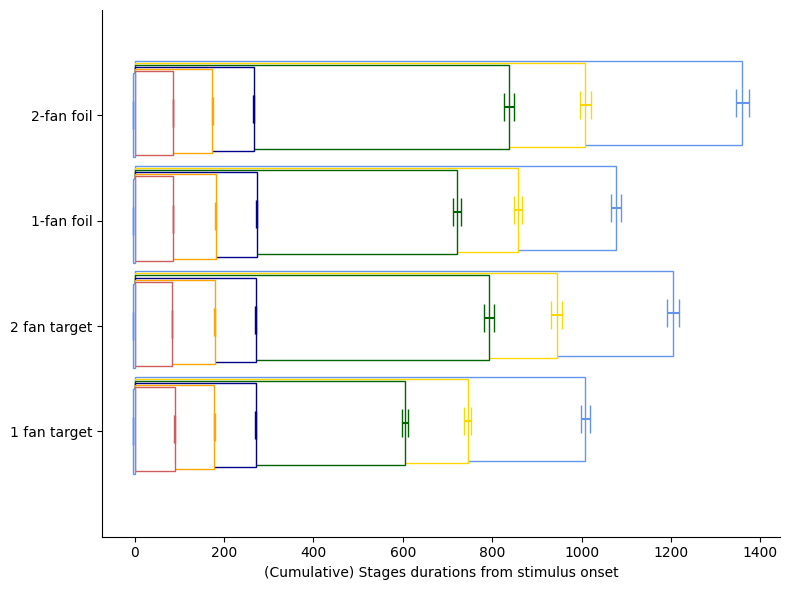

In [20]:
hsmm.visu.plot_latencies_average(condition_times, init_1.bump_width_samples, 1000/init_1.sf, 
                labels= ['1 fan target', '2 fan target', '1-fan foil', '2-fan foil'], errs='ci');

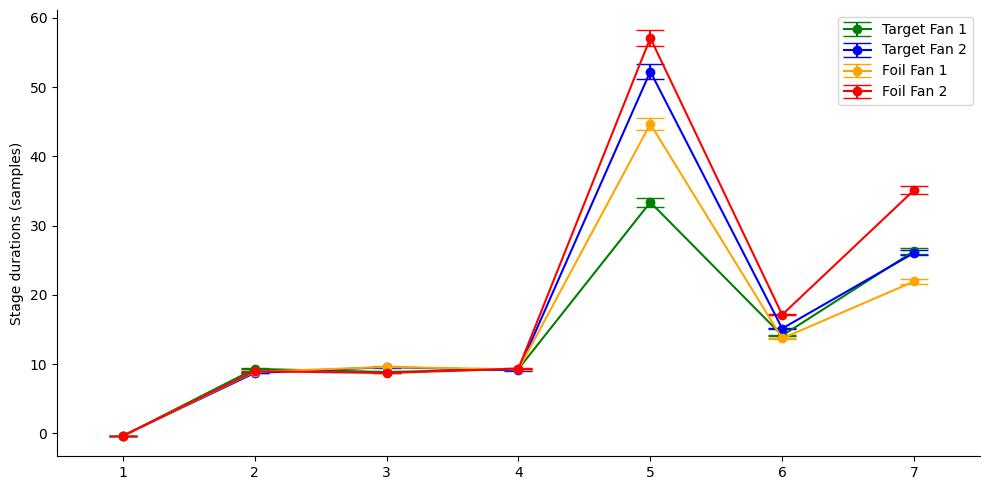

In [21]:
hsmm.visu.plot_latencies(condition_times,
    init.bump_width_samples, kind='point',legend=True,
    labels = ['Target Fan 1', 'Target Fan 2', 'Foil Fan 1', 'Foil Fan 2'],
    colors=["green","blue","orange","red"], figsize=(10,5));